In [ ]:
cpu_info = !lscpu
for inf_item in cpu_info.get_list():
  print(inf_item)

<h2 style= "color:Orange;"> SINGLE LABEL TEXT CLASSIFICATION </h2>
<ul>
<li> From the available <b> USAID DEEM documents </b>, when developing this model we <b>have not considered duplicated documents.</b></li>
<li> Therefore all the duplicated values were removed keeping only the first occurrence </li>
<li> As a result of removing duplicates, <b> all of these documents will belong to only of the 12 intervention areas</b></li>
    </ul>

<h3 style= "color:orange;"> Introduction to data set </h3><br>
<ul>
    <li>The data set consists of PDF documents that are mapped under the <b> Digital Ecosystem Evidence Map (DEEM) </b> for USAID’s Digital Strategy.
    <li>Out of <b> 1299 articles</b> mentioned in DEEEM, we were <b> able to access only 851 articles.</b></li>
    <li>Since at this run we are not treating the multi label problem, we had to get rid of duplicates.</li>
    <li>After removing all the duplicated documents, at the end we had a data set of <b> 615 pdfs to analyse.</b></li>
    <li>All these documents belong to one of the pre defined <b> 12 intervention areas</b>:
        <ol>
            <li>Child Protection</li>
            <li>Cyber Security</li>
            <li>Data Privacy</li>
            <li>Data Systems and Development</li>
            <li>Digital Finance </li>
            <li>Digital Inclusion</li>
            <li>Digital Information Services</li>
            <li>Digital Infrastructure</li>
            <li>Digital Literacy
            <li>Policy And regulation or Digital Services</li>
            <li>E-government</li>
            <li>Upskilling or Capacity Building</li>
        </ol>
        </ul>

<h3 style= "color:blue;"> Importing all the necessary libraries before begining </h3>

# Model

In [1]:
# import required libraries

import pandas as pd # dataframes
import numpy as np #mathematical operations

# to visualise

import plotly.express as px # plotly
from wordcloud import WordCloud # wordclouds
import matplotlib.pyplot as plt #matplot
import seaborn as sns #seaborn

# preprocessing

import re #Regular expressions
import nltk #NLP library
import spacy
import string
from bs4 import BeautifulSoup #HTML tags
from nltk.corpus import stopwords #english stopwords
#lematising
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

# Vectorisation

from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

# Treating class imbalanced data

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

# model building

from sklearn.model_selection import train_test_split

# algorithms

from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

# checking up with models

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
# confusion matrix
from sklearn import metrics
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


<h3 style= "color:blue;"> Importing Data Set </h3>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [48]:
# load your dataframe
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Research/Method 1 - Articles /Preprocessed.csv",index_col=[0])

<h3 style= "color:blue;"> Have a look </h3>

In [49]:
#observing data frame
df.head()

,fileclass,content
0,ChildProtection,trend child sexual abuse material trend child ...
1,ChildProtection,covid remote eliminate female genital mutilati...
2,ChildProtection,journal medium subsequent selfharm followup ch...
3,ChildProtection,original ar sexual exploitation abuse child ph...
4,ChildProtection,covid implication protect child april covid pr...


In [30]:
# do not run this!!!

# Calculate the frequency of each class
class_frequencies = df['fileclass'].value_counts().sort_values(ascending=False)

# Sort the classes in descending order based on frequency
sorted_classes = class_frequencies.index.tolist()

# Create a new DataFrame to store the reordered records
new_df = pd.DataFrame()

# Iterate through the sorted classes and append records to the new DataFrame
for class_label in sorted_classes:
    class_data = df[df['fileclass'] == class_label]
    new_df = pd.concat([new_df, class_data])

# Reset the index of the new DataFrame
new_df = new_df.reset_index(drop=True)

<h3> Data types </h3>

In [33]:
#data types
df.dtypes

fileclass    object
content      object
dtype: object

In [50]:
# change both types into string
df['content'] = df['content'].astype('str')
df['fileclass'] = df['fileclass'].astype('str')

<h3> Size </h3>

In [51]:
# size of the data frame
df.size

1702

In [52]:
# spread of the data frame
print("No. of text files: ",df.shape[0])

No. of text files:  851


<h3> Spread of text files based on intervention areas </h3>

In [37]:
# Count the number of items per group
group_counts = df.groupby("fileclass").count()
group_counts=group_counts.reset_index()

# Create the bar chart
fig = px.bar(group_counts, x='fileclass', y='content',color="fileclass")

# Show the chart
fig.show()

<h3> Treat duplicates </h3>

In [53]:
# check if there are duplicates
df.duplicated(subset=['content']).any() #no duplicates

True

Which means there are duplicates at the moment.

In [54]:
# remove duplicates, leaving the first record
df = df.drop_duplicates(subset=['content'],keep="first")

In [55]:
# spread of the data frame after remocing duplicates
print("No. of text files: ",df.shape[0])

No. of text files:  615


In [41]:
# spread of text files after removing duplicates
# Count the number of items per group
group_counts = df.groupby("fileclass").count()
group_counts=group_counts.reset_index()

# Create the bar chart
fig = px.bar(group_counts, x='fileclass', y='content',color="fileclass")

# Show the chart
fig.show()

<h3> Word Cloud </h3>

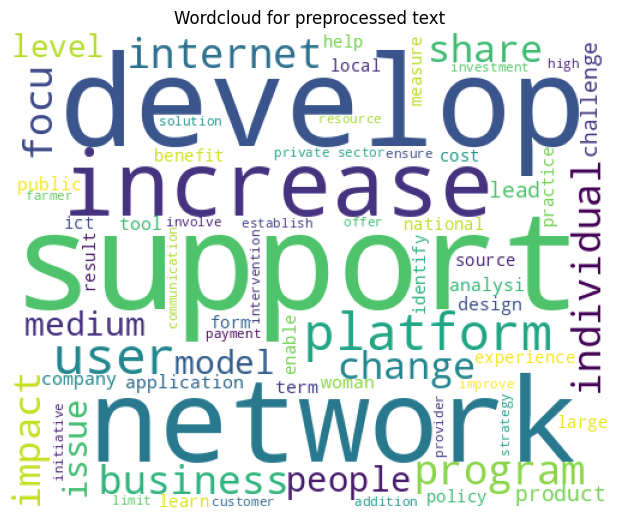

In [ ]:
# word cloud to check the overall spread of words

all_words = ''

# to extract most common words
for arg in df["content"]:

    tokens = arg.split()

    all_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 500, height = 400,
                background_color ='white',
                min_font_size = 10).generate(all_words)

# plot the WordCloud image
plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(wordcloud)
plt.title("Wordcloud for preprocessed text")
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [56]:
# Convert filecalss into int values
classes={'ChildProtection':'Child Protection','Cybersecurity':'Cybersecurity','DataPrivacy':'Data Privacy','DataSystemsDevelopment':'Data Systems Development',
         'DigitalFinance':'Digital Finance','DigitalInclusion':'Digital Inclusion','DigitalInformatioServices':'Digital Information Services',
         'DigitalInfrastructure':'Digital Infrastructure','DigitalLiteracy':'Digital Literacy','DigitalServices':'Digital Services','Egovernment':'E-government','Upskilling':'Upskilling'
         }
# map the filecalss values
df['classes']=df['fileclass'].map(classes)

# drop the fileclass axis
df.drop(['fileclass'], axis=1,inplace=True)

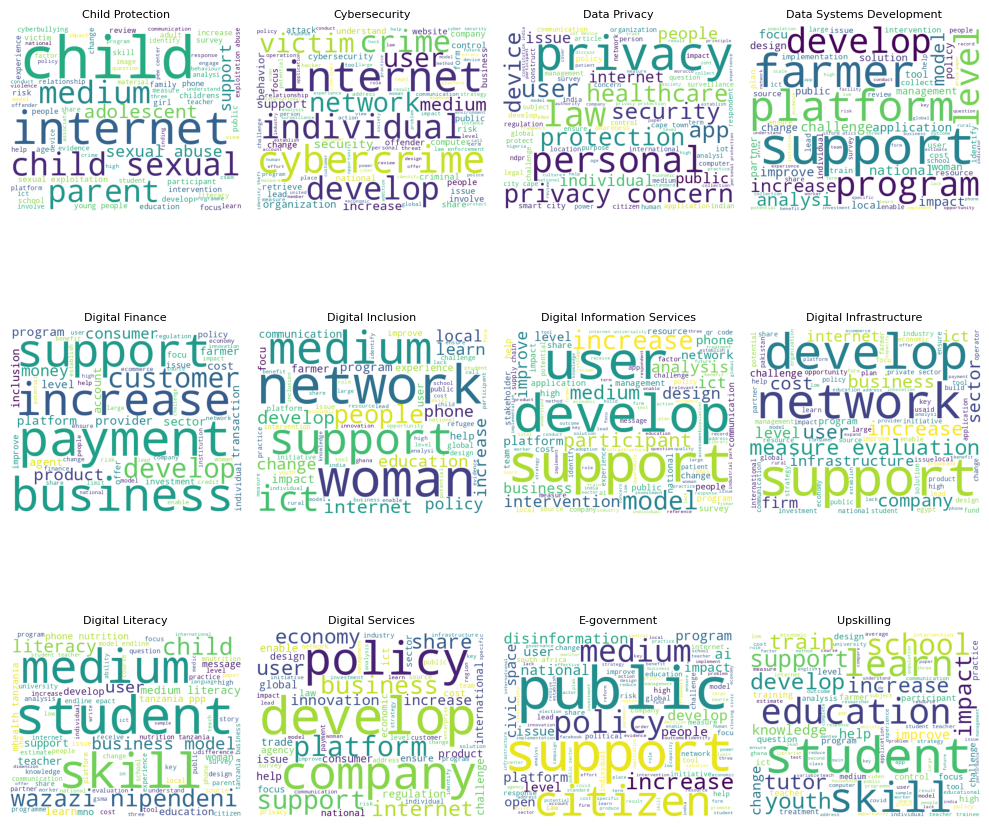

In [17]:
# word clouds based on intervention areas

# Get all the unique classes in the dataset
classes = df['classes'].unique()

# Create a figure with 4 subplots
fig, axs = plt.subplots(3, 4, figsize=(10, 10))
axs = axs.ravel()

# Iterate through each class
for i, class_name in enumerate(classes):
    # Get all the text for the current class
    class_text = df[df['classes'] == class_name]['content'].str.cat(sep=' ')
    # Generate the wordcloud
    wordcloud = WordCloud(width = 500, height = 400,
                background_color ='white',
                #olormap="ocean",
                min_font_size = 10).generate(class_text)
    # Plot the wordcloud
    axs[i].imshow(wordcloud)
    axs[i].set_title(f"{class_name}",fontsize=8)
    axs[i].axis("off")
fig.tight_layout()
plt.show()

<h3> Document term matrix</h3>

In [43]:
# Group the dataframe by the 'fileclass' column
grouped = df.groupby('classes')

# Create an empty dataframe to store the results
tfidf_df = pd.DataFrame()

# Iterate through each group
for name, group in grouped:
    # Apply the TfidfVectorizer to the 'content' column for the current group
    vectorizer = TfidfVectorizer(stop_words=None, max_features=10000000)
    tfidf = vectorizer.fit_transform(group['content']).mean(axis=0)
    # Convert the matrix to a dataframe
    tfidf_df[name] = pd.Series(tfidf.tolist()[0], index=vectorizer.get_feature_names_out())


In [44]:
# observe the dataframe
tfidf_df

,Child Protection,Cybersecurity,Data Privacy,Data Systems Development,Digital Finance,Digital Inclusion,Digital Information Services,Digital Infrastructure,Digital Literacy,Digital Services,E-government,Upskilling
aaron,0.000176,0.000125,NaN,0.000421,0.000325,NaN,0.000763,0.000561,NaN,0.000723,0.000053,0.000426
ababa,0.000973,0.000074,NaN,0.000538,0.000232,0.000521,0.000551,0.000368,0.002904,0.000684,0.000158,0.000729
abandon,0.000231,0.000127,NaN,0.000488,0.000204,0.000302,0.000428,0.000187,0.000236,0.000690,0.000673,0.000653
abandonment,0.000231,0.000045,NaN,0.000087,0.000040,0.000289,NaN,NaN,NaN,NaN,NaN,NaN
abbreviation,0.001332,0.000613,0.000856,0.000992,0.000663,0.000694,0.000597,0.001174,0.000901,0.001137,0.000733,0.000474
...,...,...,...,...,...,...,...,...,...,...,...,...
zone,0.008118,0.001792,0.000779,0.001553,0.001005,0.004201,0.002258,0.002460,0.000415,0.002136,0.000658,NaN
zoom,0.001683,0.000042,NaN,0.000452,0.000276,0.000929,0.000137,0.001324,NaN,0.000443,0.000056,0.001255
zuckerberg,0.000360,0.000166,NaN,NaN,NaN,0.000226,NaN,0.000273,NaN,0.001796,0.000183,NaN
zusammenarbeit,0.000428,NaN,NaN,0.000058,0.000170,0.000130,0.000284,NaN,NaN,NaN,NaN,NaN


<h3 style= "color:blue;"> Check for class imbalanced nature </h3>

As you can see the data set is class imbalanced.




<b> Before moving ahead let's convert the fileclass into integer format, as it will make
our work easy!!</b>

In [57]:
# Convert filecalss into int values
classes={'Child Protection':0,'Cybersecurity':1,'Data Privacy':2,'Data Systems Development':3,
         'Digital Finance':4,'Digital Inclusion':5,'Digital Information Services':6,
         'Digital Infrastructure':7,'Digital Literacy':8,'Digital Services':9,'E-government':10,'Upskilling':11
         }
# map the filecalss values
df['classes']=df['classes'].map(classes)

<b> After all these let's have a look on the final data frame </b>

In [58]:
df.head()

,content,classes
0,trend child sexual abuse material trend child ...,0
1,covid remote eliminate female genital mutilati...,0
2,journal medium subsequent selfharm followup ch...,0
3,original ar sexual exploitation abuse child ph...,0
4,covid implication protect child april covid pr...,0


<b> Now we have to vectorise our content column </b>

In [59]:
# vectorsing the content column
vectorizer = TfidfVectorizer(stop_words=None)
vectorized_df = vectorizer.fit_transform(df['content'])
# defining the y label
y = df['classes']
y=y.to_frame()

<h3 style= "color:blue;"> Defining train and test set </h3>

In [60]:
# train test split
X_train, x_test, Y_train, y_test = train_test_split(vectorized_df,y,test_size=0.3,random_state=42)

<b> Finally we can get rid of class imbalanced data</b>

In [ ]:
pip install -U imbalanced-learn

In [61]:
# treat class imbalanced data
ros = RandomOverSampler(random_state=42)
X_train, Y_train = ros.fit_resample(X_train, Y_train)

In [62]:
# visualise the class balanced data set
# Count the number of samples for each class in the oversampled dataset
class_counts = Y_train['classes'].value_counts()

# Create a bar chart using plotly
fig = px.bar(class_counts, x=class_counts.index, y=class_counts.values)
fig.show()

<h3 style= "color:blue;"> Fit  Models </h3>

<h3> Random Forest</h3>

In [65]:
# fit the model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, Y_train.values.ravel())

#make predictions
pred_rf = rf.predict(x_test)

#print accuracy
print("Accuracy %s" % accuracy_score(pred_rf,y_test))

Accuracy 0.4486486486486487


In [66]:
print(classification_report(y_test,pred_rf))

              precision    recall  f1-score   support

           0       0.89      0.73      0.80        11
           1       0.38      0.62      0.48         8
           2       0.00      0.00      0.00         9
           3       0.29      0.21      0.24        28
           4       0.66      0.96      0.78        49
           5       0.28      0.50      0.35        22
           6       0.22      0.50      0.31        12
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         9
          10       0.00      0.00      0.00        19
          11       0.00      0.00      0.00        10

    accuracy                           0.45       185
   macro avg       0.23      0.29      0.25       185
weighted avg       0.34      0.45      0.37       185



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



<h3> Decision Trees </h3>

In [67]:
# fit the model
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, Y_train.values.ravel())

# make predictions
pred_dt = dt.predict(x_test)

# print accuracy
print("Accuracy %s" % accuracy_score(pred_dt,y_test))

Accuracy 0.31351351351351353


In [68]:
print(classification_report(y_test,pred_dt))

              precision    recall  f1-score   support

           0       0.75      0.27      0.40        11
           1       0.38      0.38      0.38         8
           2       0.67      0.44      0.53         9
           3       0.38      0.21      0.27        28
           4       0.68      0.51      0.58        49
           5       0.16      0.23      0.19        22
           6       0.12      0.33      0.18        12
           7       0.13      0.29      0.18         7
           8       0.00      0.00      0.00         1
           9       0.30      0.33      0.32         9
          10       0.22      0.11      0.14        19
          11       0.12      0.10      0.11        10

    accuracy                           0.31       185
   macro avg       0.33      0.27      0.27       185
weighted avg       0.40      0.31      0.34       185



<h3> Naive Bayes </h3>

In [70]:
# fit the model
nb = MultinomialNB()
nb.fit(X_train, Y_train.values.ravel())

# make predictions
pred_nb = nb.predict(x_test)

# print accuracy
print("Accuracy %s" % accuracy_score(pred_nb,y_test))

Accuracy 0.42702702702702705


In [71]:
print(classification_report(y_test,pred_nb))

              precision    recall  f1-score   support

           0       0.90      0.82      0.86        11
           1       0.75      0.75      0.75         8
           2       0.40      0.22      0.29         9
           3       0.30      0.11      0.16        28
           4       0.92      0.71      0.80        49
           5       0.67      0.36      0.47        22
           6       0.17      0.25      0.20        12
           7       0.18      0.43      0.25         7
           8       0.00      0.00      0.00         1
           9       0.17      0.78      0.29         9
          10       0.22      0.11      0.14        19
          11       0.20      0.10      0.13        10

    accuracy                           0.43       185
   macro avg       0.41      0.39      0.36       185
weighted avg       0.53      0.43      0.45       185



<h3> K-Nearest Neighbours </h3>

In [72]:
# fit the model
knn = KNeighborsClassifier()
knn.fit(X_train, Y_train.values.ravel())

# make predictions
pred_knn = knn.predict(x_test)

# print accuracy
print("Accuracy %s" % accuracy_score(pred_knn,y_test))

Accuracy 0.3891891891891892


In [73]:
print(classification_report(y_test,pred_knn))

              precision    recall  f1-score   support

           0       0.67      0.55      0.60        11
           1       0.33      0.50      0.40         8
           2       1.00      0.22      0.36         9
           3       0.41      0.25      0.31        28
           4       0.82      0.55      0.66        49
           5       0.48      0.45      0.47        22
           6       0.37      0.58      0.45        12
           7       0.04      0.14      0.07         7
           8       0.00      0.00      0.00         1
           9       0.15      0.33      0.21         9
          10       0.45      0.26      0.33        19
          11       0.00      0.00      0.00        10

    accuracy                           0.39       185
   macro avg       0.39      0.32      0.32       185
weighted avg       0.52      0.39      0.42       185



<h3> Logistic Regression </h3>

In [93]:
# fit the model
lr = LogisticRegression()
lr.fit(X_train, Y_train.values.ravel())

# make predictions
pred_lr = lr.predict(x_test)

# print accuracy
print("Accuracy %s" % accuracy_score(pred_lr,y_test))

Accuracy 0.5297297297297298


In [94]:
print(classification_report(y_test,pred_lr))

              precision    recall  f1-score   support

           0       1.00      0.64      0.78        11
           1       0.60      0.75      0.67         8
           2       0.00      0.00      0.00         9
           3       0.46      0.43      0.44        28
           4       0.83      0.82      0.82        49
           5       0.50      0.55      0.52        22
           6       0.23      0.58      0.33        12
           7       0.30      0.43      0.35         7
           8       0.00      0.00      0.00         1
           9       0.30      0.33      0.32         9
          10       0.60      0.32      0.41        19
          11       0.40      0.20      0.27        10

    accuracy                           0.53       185
   macro avg       0.44      0.42      0.41       185
weighted avg       0.56      0.53      0.53       185



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [95]:
classes=['Child Protection','Cybersecurity','Data Privacy','Data Systems Dev',
         'Digital Finance','Digital Inclusion','Digital IS',
         'Digital Infrastructure','Digital Literacy','Digital Services','E-government','Upskilling'
]

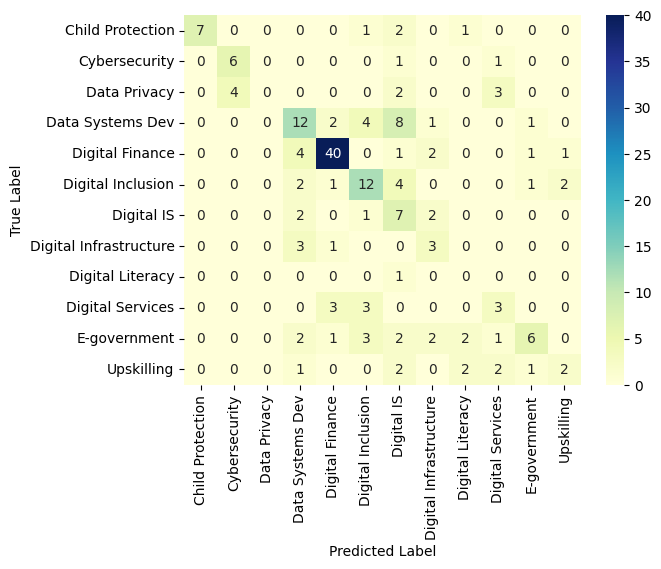

In [97]:
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, pred_lr)

import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(conf_matrix, annot = True, xticklabels=classes,yticklabels=classes,cmap = "YlGnBu")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

<h3> Ada Boost </h3>

In [78]:
# fit the model
ab = AdaBoostClassifier()
ab.fit(X_train, Y_train.values.ravel())

# make predictions
pred_ab = ab.predict(x_test)

# print accuracy
print("Accuracy %s" % accuracy_score(pred_ab,y_test))

Accuracy 0.07027027027027027


In [79]:
print(classification_report(y_test, pred_ab, zero_division=1))

              precision    recall  f1-score   support

           0       1.00      0.18      0.31        11
           1       0.40      0.25      0.31         8
           2       1.00      0.00      0.00         9
           3       1.00      0.00      0.00        28
           4       1.00      0.00      0.00        49
           5       1.00      0.00      0.00        22
           6       1.00      0.00      0.00        12
           7       0.04      1.00      0.08         7
           8       0.00      0.00      0.00         1
           9       0.22      0.22      0.22         9
          10       1.00      0.00      0.00        19
          11       1.00      0.00      0.00        10

    accuracy                           0.07       185
   macro avg       0.72      0.14      0.08       185
weighted avg       0.89      0.07      0.05       185



<h3> SGD </h3>

In [80]:
# fit the model
sgd = SGDClassifier()
sgd.fit(X_train, Y_train.values.ravel())

# make predictions
pred_sgd = sgd.predict(x_test)

# print accuracy
print("Accuracy %s" % accuracy_score(pred_sgd,y_test))

Accuracy 0.4972972972972973


In [81]:
print(classification_report(y_test,pred_sgd))

              precision    recall  f1-score   support

           0       1.00      0.64      0.78        11
           1       0.56      0.62      0.59         8
           2       0.00      0.00      0.00         9
           3       0.42      0.39      0.41        28
           4       0.81      0.80      0.80        49
           5       0.39      0.64      0.48        22
           6       0.17      0.33      0.23        12
           7       0.14      0.14      0.14         7
           8       0.00      0.00      0.00         1
           9       0.14      0.11      0.12         9
          10       0.57      0.42      0.48        19
          11       0.50      0.20      0.29        10

    accuracy                           0.50       185
   macro avg       0.39      0.36      0.36       185
weighted avg       0.52      0.50      0.50       185



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



<h3> Support Vectore Machine </h3>

In [82]:
# fit the model
svc = SVC()
svc.fit(X_train, Y_train.values.ravel())

# make predictions
pred_svc = svc.predict(x_test)

# print accuracy
print("Accuracy %s" % accuracy_score(pred_svc,y_test))

Accuracy 0.4702702702702703


In [83]:
print(classification_report(y_test,pred_svc))

              precision    recall  f1-score   support

           0       1.00      0.55      0.71        11
           1       0.80      0.50      0.62         8
           2       0.00      0.00      0.00         9
           3       0.41      0.39      0.40        28
           4       0.66      0.90      0.76        49
           5       0.29      0.73      0.41        22
           6       0.21      0.25      0.23        12
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00         1
           9       0.33      0.11      0.17         9
          10       0.50      0.11      0.17        19
          11       0.00      0.00      0.00        10

    accuracy                           0.47       185
   macro avg       0.35      0.29      0.29       185
weighted avg       0.45      0.47      0.42       185



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



<h3> Ensemble </h3>

In [84]:
from sklearn.ensemble import VotingClassifier

# Create instances of the SGDClassifier and RandomForestClassifier
sgd = SGDClassifier()
rf = RandomForestClassifier()

# Create an instance of the VotingClassifier
ensemble = VotingClassifier(estimators=[('sgd', sgd), ('rf', rf)], voting='hard')

# Fit the VotingClassifier to the data
ensemble.fit(X_train, Y_train.values.ravel())

# Make predictions
pred_ensemble = ensemble.predict(x_test)

# Print accuracy
print("Accuracy %s" % accuracy_score(pred_ensemble, y_test))

Accuracy 0.4702702702702703


In [85]:
print(classification_report(y_test,pred_ensemble))

              precision    recall  f1-score   support

           0       1.00      0.73      0.84        11
           1       0.41      0.88      0.56         8
           2       1.00      0.11      0.20         9
           3       0.41      0.50      0.45        28
           4       0.69      0.86      0.76        49
           5       0.29      0.55      0.38        22
           6       0.13      0.17      0.15        12
           7       0.33      0.14      0.20         7
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         9
          10       0.00      0.00      0.00        19
          11       0.00      0.00      0.00        10

    accuracy                           0.47       185
   macro avg       0.36      0.33      0.30       185
weighted avg       0.43      0.47      0.42       185



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



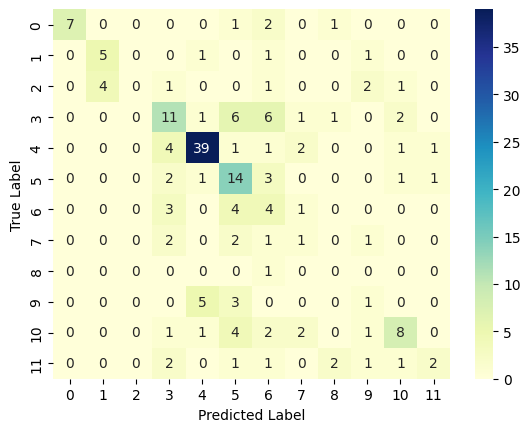

In [86]:
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, pred_sgd)

import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(conf_matrix, annot = True, fmt = "d", cmap = "YlGnBu")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#<h3 style= "color:blue;"> User Case </h3>

In [ ]:
def predict_class(text, model, vectorizer, class_mapping):
    # Transform the input text using the fitted vectorizer
    text_vector = vectorizer.transform([text])
    # Use the trained model to predict the class
    prediction = model.predict(text_vector)[0]
    # Map the numeric value to class label using the class_mapping dataframe
    class_label = class_mapping.loc[class_mapping['class_value'] == prediction, 'class_label'].values[0]
    return class_label

In [ ]:
# Example usage
text = input("Enter text to classify: ")

In [ ]:
# predict the class of input document
predicted_class = predict_class(text, sgdh, vectorizer,class_mapping)
print("The predicted class is: ", predicted_class)